# Markov chain model demo

This notebokk aims to show functioning of the **MK_chain** class created in order to improve existing algos. This notebook will use trip prediction as an exemple of usecase but the model can be used for any discrete event prediction

### Section 1 : Imports

Nothing particular of note here, pandas and numpy are used to manipulate data and *create_dataframe* is a custom parsing function for the provided dataset

In [1]:
# Graph display and style
import matplotlib.pyplot as plt
import seaborn as sns

# Data management
import numpy as np
import pandas as pd

# Custom function for parsing and import for graph size 
from data_parsing import create_dataframe
from matplotlib.pyplot import figure


### Section 2 : Class definition 

The **MK_chain** class has two important variables being **transitionMatrix** and **gamma**. These two being central to the Markov model and used to make predictions later on. Most class methods below are used to compute and update these two objects.
Note: The dataframe is saved as a class variable for ease of use

In [2]:
class MK_chain:
    def __init__(self, df):
        """__init__ Markov chain Class constructor

        Arguments:
            Prob_mat  -- Transition matrix of the markov chain

        Raises:
            ValueError: Sum of probibilities in a given row should always add up to 1
        """
        self.data_frame = df

        self.trips_nb = []
        self.Start_clusters = []
        self.End_clusters = []
        self.sum_mat = []
        self.TOLERANCE_VALUE = 0.0001

        self.Start_clusters = self.data_frame['gps_start_cluster'].unique()
        self.Start_clusters.sort()
        self.End_clusters = self.data_frame['gps_end_cluster'].unique()
        self.End_clusters.sort()

        self.create_transition_matrix()

    def create_sum_matrix(self):

        for Start in self.Start_clusters:
            Total = 0
            Starting_points = self.data_frame.loc[self.data_frame['gps_start_cluster'] == Start]

            for End in self.End_clusters:
                Ending_points = Starting_points.loc[Starting_points['gps_end_cluster'] == End]
                Total = len(Ending_points)

                self.sum_mat.append([Start, End, Total])

    def create_proba_vector(self, Start):

        size = max(self.End_clusters[-1], self.Start_clusters[-1])
        if size == 1:
            size = 1

        proba_vector = np.zeros(size+1)
        starting_points = self.data_frame.loc[self.data_frame['gps_start_cluster'] == Start]
        sample = len(starting_points)

        for freq in self.sum_mat:
            if freq[0] == Start:
                proba_vector[freq[1]] = (freq[2]/sample)*100
        return proba_vector

    def create_gamma(self):
        gamma = []
        sample = len(self.data_frame)

        for start in self.Start_clusters:
            df_s = self.data_frame.loc[self.data_frame['gps_start_cluster'] == start]
            gamma.append((len(df_s)/sample)*100)
        if sum(gamma) > 100.5:
            raise ValueError("Gamma matrix coefficients not adding up to 1")
        return gamma

    def create_transition_matrix(self):

        self.create_sum_matrix()

        size = max(self.End_clusters[-1], self.Start_clusters[-1])
        if size == 0:
            size = 1
        t_mat = np.array(self.create_proba_vector(0))

        for i in range(1, size+1):
            vect = self.create_proba_vector(i)
            t_mat = np.vstack((t_mat, vect))

        self.gamma = self.create_gamma()
        self.transitionMatrix = t_mat

        self.states = [str(x) for x in range(len(self.transitionMatrix))]

        return self.gamma, t_mat

    def fit(self, new):

        start = new['gps_start_cluster'].values
        end = new['gps_end_cluster'].values

        frames = [self.data_frame, new]
        self.data_frame = pd.concat(frames)

        if (start > self.Start_clusters[-1] or end > self.End_clusters[-1]):
            self.Start_clusters = self.data_frame['gps_start_cluster'].unique()
            self.Start_clusters.sort()
            self.End_clusters = self.data_frame['gps_end_cluster'].unique()
            self.End_clusters.sort()

            self.create_transition_matrix()

        else:
            self.Start_clusters = self.data_frame['gps_start_cluster'].unique()
            self.Start_clusters.sort()
            self.End_clusters = self.data_frame['gps_end_cluster'].unique()
            self.End_clusters.sort()

            for start_point in start:
                for end_point in end:
                    for freq in self.sum_mat:

                        if (freq[0] == start_point and freq[1] == end_point):
                            new_id = self.sum_mat.index(freq)
                            self.sum_mat[new_id][2] += 1

            for i in start:
                vect = self.create_proba_vector(i)
                self.transitionMatrix[i] = vect
                self.gamma = self.create_gamma()

    def predict(self, curr_st):

        if curr_st in self.states:
            st_id = self.states.index(curr_st)
            most_likely = max(self.transitionMatrix[st_id])
            pred_id = np.where(self.transitionMatrix[st_id] == most_likely)[0][0]
            return self.states[pred_id]
        else:
            return('-1')

### Section 3 : Markov chain creation / updating

To create the markov chain, the model calls **create_transition_matrix** which in turn calls **create_sum_matrix**, **create_proba_vector** and **create_gamma** to go through the dataframe given as an argument, and compute the chance of each start_cluster to end_cluster combination. Once these are known, they are saved in **transitionMatrix**.

In [3]:
df_travel = create_dataframe()
df_travel = df_travel.sample(frac=1) #randomize the dataframe order, for consistency

df_train = df_travel.sample(frac=0.7)
df_test = df_travel.drop(df_train.index)
print(len(df_test))

df_travel.head()

15


,start_ts,end_ts,start_hour,end_hour,start_hour_hmin,end_hour_hmin,start_hour_sin,start_hour_cos,end_hour_sin,end_hour_cos,...,start_gps_label,end_gps_label,travel_distance_km,start_gps_coord,end_gps_coord,travel_gps_list,gps_start_cluster,gps_end_cluster,gps_start_cluster_label,gps_end_cluster_label
37,1559659636876,1559662753244,16.783333,17.650000,16:47,17:39,-0.949699,-0.313164,-0.995805,-0.091502,...,"Camaïeu, 58, Avenue de Fouilleuse, Buzenval, V...","Crèche Fée Clochette, Rue des Carrières, Quart...",8.282643,"[48.8624, 2.19482]","[48.8665, 2.2203]","[[1559659635989.0, 48.8624, 2.19482], [1559659...",1,2,"Camaïeu, 58, Avenue de Fouilleuse, Buzenval, V...","Crèche Fée Clochette, Rue des Carrières, Quart..."
12,1558289209443,1558290362848,20.100000,20.433333,20:06,20:26,-0.852640,0.522499,-0.803857,0.594823,...,"Challenge 92, Avenue François Arago, La Défens...","Avenue Alfred Belmontet, Saint-Cloud, Arrondis...",7.040414,"[48.9004, 2.22391]","[48.8545, 2.21826]","[[1558289209000.0, 48.9004, 2.22391], [1558289...",3,0,"Avenue François Arago, La Défense 7, Quartier ...","Avenue Alfred Belmontet, Saint-Cloud, Arrondis..."
22,1558676250842,1558677188843,7.616667,7.883333,7:37,7:53,0.911762,-0.410719,0.880891,-0.473320,...,"Avenue Alfred Belmontet, Saint-Cloud, Arrondis...","École primaire publique Marcel Mouloudji, Rue ...",2.790196,"[48.8546, 2.21789]","[48.8656, 2.2212]","[[1558676250000.0, 48.8546, 2.21789], [1558676...",0,2,"Avenue Alfred Belmontet, Saint-Cloud, Arrondis...","Crèche Fée Clochette, Rue des Carrières, Quart..."
27,1559213334956,1559214036546,12.800000,13.000000,12:48,13:00,-0.207912,-0.978148,-0.258819,-0.965926,...,"Avenue Alfred Belmontet, Saint-Cloud, Arrondis...","Parc de stationnement des Hauts de Rueil, Entr...",2.579570,"[48.8547, 2.218]","[48.8614, 2.19416]","[[1559213333000.0, 48.8547, 2.218], [155921334...",0,1,"Avenue Alfred Belmontet, Saint-Cloud, Arrondis...","Voyages E.Leclerc, Entrée Suresnes, Village Bu..."
15,1558368807002,1558369518073,18.216667,18.416667,18:13,18:25,-0.998392,0.056693,-0.994056,0.108867,...,"21, Rue des Carrières, Quartier République, Su...","Avenue Alfred Belmontet, Saint-Cloud, Arrondis...",1.693589,"[48.8664, 2.22035]","[48.8546, 2.2179]","[[1558368807000.0, 48.8664, 2.22035], [1558368...",2,0,"21, Rue des Carrières, Quartier République, Su...","Avenue Alfred Belmontet, Saint-Cloud, Arrondis..."


Here we first create an "true" transition matrix, by giving to the markov model the whole dataframe at once, this will be used to verify the effectiveness of our update methods below. At first, the matrix are obviously different. Then after calling the **fit** method on each remaining line, they end up equal

In [4]:
mk_true = MK_chain(df=df_travel)
print(np.matrix(mk_true.transitionMatrix))

[[  0.          27.27272727  27.27272727  45.45454545   0.        ]
 [ 80.           0.          20.           0.           0.        ]
 [ 72.72727273   0.           9.09090909  18.18181818   0.        ]
 [100.           0.           0.           0.           0.        ]
 [ 77.77777778   0.          22.22222222   0.           0.        ]]


In [5]:
mk_travel = MK_chain(df=df_train)
print(np.matrix(mk_travel.transitionMatrix))

[[  0.          25.          37.5         37.5          0.        ]
 [ 75.           0.          25.           0.           0.        ]
 [ 83.33333333   0.           0.          16.66666667   0.        ]
 [100.           0.           0.           0.           0.        ]
 [100.           0.           0.           0.           0.        ]]


In [6]:
for r_id in range(len(df_test)):
    mk_travel.fit(df_test.iloc[[r_id]])
print(np.matrix(mk_travel.transitionMatrix))

[[  0.          27.27272727  27.27272727  45.45454545   0.        ]
 [ 80.           0.          20.           0.           0.        ]
 [ 72.72727273   0.           9.09090909  18.18181818   0.        ]
 [100.           0.           0.           0.           0.        ]
 [ 77.77777778   0.          22.22222222   0.           0.        ]]


### Section 4 : Checking model performance

Now that we made sure the Markov chain was able to update itself as we go, we can check its performances. Checking it every time a new trip is added allows us to find how fast the model can start to be precise enough, which is an important parameter for the choice of algo later on. Below is a function used to test the model accuracy

In [7]:
def evaluate_mk(df, mk):
    acc_total = 0
    for r_id in range(len(df)):

        row = df.iloc[[r_id]]
        start = row['gps_start_cluster'].values
        pred = mk.predict(str(start[0]))
        answ = str(row['gps_end_cluster'].values[0])

        if pred == answ:
            acc_total += 1
    return (acc_total/len(df))*100

By creating the markov chain with a randomly selected line of the dataframe and calling this function, we can check the theoritical progression of accuracy as time goes by. We do this 9 times to avoid anomalies corrupting our results (this happens often with very small and skewed dataset like ours)

In [8]:
epoch_acc = []

for i in range(10):
    df_travel = create_dataframe()
    df_travel = df_travel.sample(frac=1)

    df_data = df_travel[:1]
    df_travel = df_travel.drop(df_data.index)
    df_train = df_travel.sample(frac=0.7)
    df_test = df_travel.drop(df_train.index)

    mk_travel = MK_chain(df=df_data)
    model_acc = []

    for r_id in range(len(df_train)):
        mk_travel.fit(df_train.iloc[[r_id]])
        model_acc.append(evaluate_mk(df_test, mk_travel))

    epoch_acc.append(model_acc)

Now that the tests are done, we display the results on plots. To better see how each epoch went compared to others and thus show the anomalies, we represent it by highlighting them one by one, and putting every other result in the background

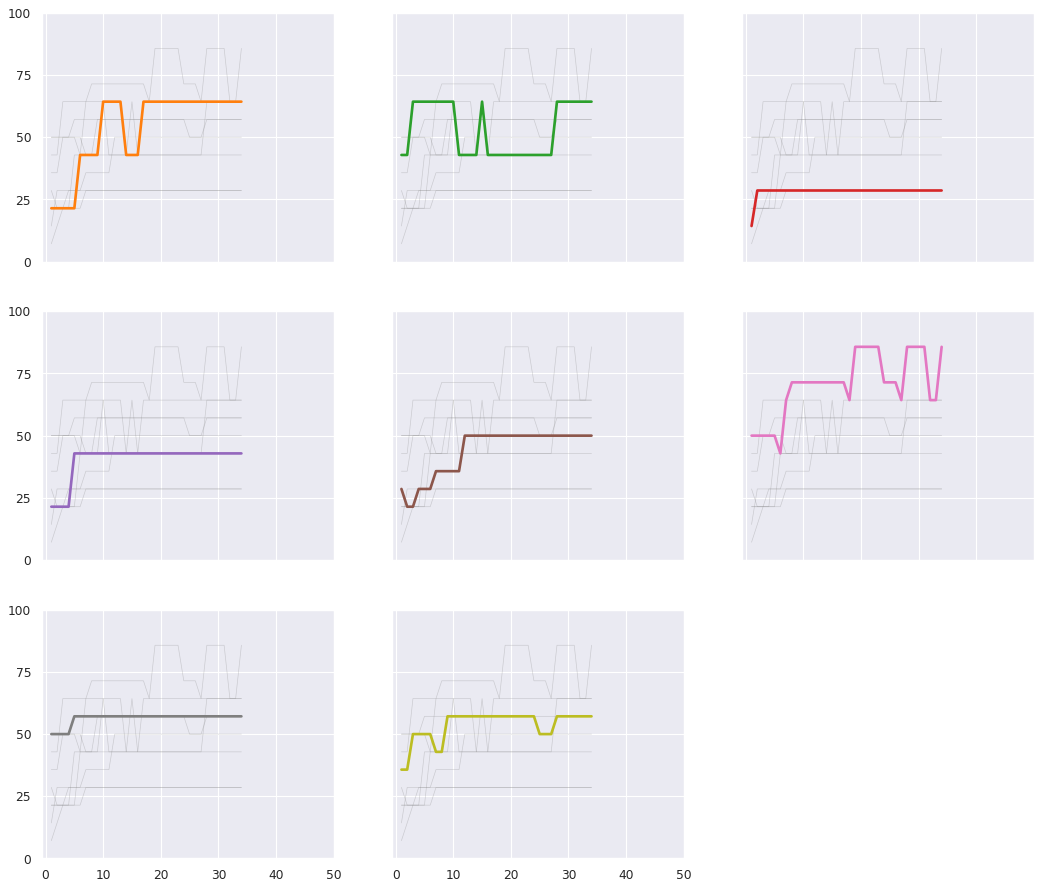

In [9]:
sns.set_theme()
palette = plt.get_cmap('tab10')
figure(figsize=(16, 14), dpi=80)

trainset_lenghts = list(range(1, len(df_train)+1))
for k in range(1, 9):
    plt.subplot(3, 3, k)
    for epoch in range(1, 10):
        plt.plot(trainset_lenghts, epoch_acc[epoch], marker='', color='grey', linewidth=0.6, alpha=0.3)
    plt.plot(trainset_lenghts, epoch_acc[k], marker='', color=palette(k), linewidth=2.4, alpha=1)

    y_ticks = np.arange(0, 101, 25)
    x_ticks = np.arange(0, 51, 10)
    ax = plt.gca()
    # Not ticks everywhere
    if k not in [7, 8, 9]:
        ax.set_xticklabels([])
    if k not in [1, 4, 7]:
        ax.set_yticklabels([])

    ax.set_ylim([0, 100])
    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)

plt.show()

# Note importante !
Ces résultats sont calculés sans l'utilisation du vecteur gamma, qui est calculé par la classe MK_chain. On ne les montre pas ici car ils sont trop biaisés par la répartition de la database fournie

In [10]:
df_travel.head()[['start_hour_hmin', 'start_gps_coord', 'start_hour_hmin','end_gps_coord', 'travel_distance_km']]

,start_hour_hmin,start_gps_coord,start_hour_hmin,end_gps_coord,travel_distance_km
1,15:40,"[48.8623, 2.19501]",15:40,"[48.8546, 2.21789]",2.698575
28,14:34,"[48.8613, 2.1943]",14:34,"[48.8546, 2.21777]",2.507783
9,15:40,"[48.8594, 2.21814]",15:40,"[48.8658, 2.21556]",1.145860
31,20:23,"[48.9004, 2.22364]",20:23,"[48.8546, 2.2179]",7.050811
43,8:17,"[48.867, 2.22057]",8:17,"[48.7654, 2.08624]",30.339328
